Importações

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import json
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder


1 - Funções de ativação e derivadas

In [40]:
import numpy as np


def sigmoid(z):
    return 1/ (1+np.exp(-z))

def d_sigmoid(z):
    s = sigmoid(z)
    return s * (1-s)

def tanh(z):
    return np.tanh(z)

def d_tanh(z):
    return 1 - np.tanh(z)**2

def relu(z):
    return np.maximum(0,z)

def d_relu(z):
    return (z > 0).astype(float) 

def leaky_relu(z,alpha=0.01):
    return np.where(z > 0,z, alpha *z)

def d_leaky_relu(z, alpha=0.01):
    return np.where(z> 0, 1.0,alpha)

def linear(z):
    return z

def d_linear(z):
    return np.ones_like(z)

activation_functions = {
    'sigmoid': (sigmoid,d_sigmoid),
    'tanh': (tanh,d_tanh),
    'relu': (relu,d_relu),
    'leaky_relu': (leaky_relu,d_leaky_relu),
    'linear': (linear,d_linear)
    }

2 - Definição das funções de custo 

Definimos as funções de custo e suas respectivas derivadas para uso no treinamento da rede

In [41]:
# -------------------------
# Funções de Custo e suas Derivadas
# -------------------------
def mse_loss(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def d_mse_loss(y_true, y_pred):
    return (2 / y_true.shape[0]) * (y_pred - y_true)

def bce_loss(y_true, y_pred, epsilon=1e-8):
    # Clipping para evitar log(0)
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

def d_bce_loss(y_true, y_pred, epsilon=1e-8):
    y_pred = np.clip(y_pred, epsilon, 1 - epsilon)
    return -(y_true / y_pred) + ((1 - y_true) / (1 - y_pred))

# Mapeamento para facilitar a seleção da função de custo
cost_functions = {
    'mse': (mse_loss, d_mse_loss),
    'bce': (bce_loss, d_bce_loss)
}


3 - Inicializadores de pesos

In [42]:
def initialize_weights(n_in,n_out,method='xavier'):
    if method == 'xavier':
        std = np.sqrt(1. /n_in)
        return np.random.randn(n_in,n_out) *std
    elif method == 'he':
        std = np.sqrt(2. /n_in)
        return np.random.randn(n_in,n_out) *std
    elif method == 'normal':
        return np.random.randn(n_in,n_out) *std
    elif method == 'uniform':
        limit = np.sqrt(6 / (n_in + n_out))
        return np.random.uniform(-limit,limit,(n_in,n_out))
    else:
        raise ValueError("Metodo de inicialização desconhecido")

4 - Classe MLP: Funcionamento da rede neural forward e backward propagation, atualização de parâmetros

In [43]:
# -------------------------
# Classe MLP
# -------------------------
class MLP:
    def __init__(self, layers, activations, cost='mse', optimizer='sgd',
                 initialization='xavier', learning_rate=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
        """
        layers: lista com o número de unidades em cada camada, incluindo input e output.
        activations: lista com os nomes das funções de ativação para cada camada oculta e saída.
        cost: 'mse' ou 'bce'
        optimizer: 'sgd' ou 'adam'
        initialization: 'xavier', 'he', 'normal' ou 'uniform'
        """
        self.layers = layers
        self.num_layers = len(layers)
        self.activations = activations
        self.cost_name = cost
        self.optimizer = optimizer
        self.learning_rate = learning_rate
        self.initialization = initialization

        # Seleciona a função de custo e sua derivada
        self.cost_func, self.d_cost_func = cost_functions[cost]
        
        # Inicialização dos pesos e vieses
        self.weights = []
        self.biases = []
        for i in range(self.num_layers - 1):
            W = initialize_weights(layers[i], layers[i+1], method=initialization)
            b = np.zeros((1, layers[i+1]))
            self.weights.append(W)
            self.biases.append(b)

        # Para Adam: inicializa momentos
        if optimizer == 'adam':
            self.m_weights = [np.zeros_like(W) for W in self.weights]
            self.v_weights = [np.zeros_like(W) for W in self.weights]
            self.m_biases = [np.zeros_like(b) for b in self.biases]
            self.v_biases = [np.zeros_like(b) for b in self.biases]
            self.beta1 = beta1
            self.beta2 = beta2
            self.epsilon = epsilon
            self.t = 0  # contador de atualizações

    def forward(self, X):
        """
        Executa o forward pass e retorna as ativações e os valores z de cada camada.
        """
        activations = [X]
        zs = []  # armazenará os valores z para cada camada
        A = X
        for i in range(self.num_layers - 1):
            z = np.dot(A, self.weights[i]) + self.biases[i]
            zs.append(z)
            # Seleciona a função de ativação para a camada i
            func, _ = activation_functions[self.activations[i]]
            A = func(z)
            activations.append(A)
        return activations, zs

    def backward(self, activations, zs, y_true):
        """
        Executa o backward pass e retorna os gradientes para pesos e vieses.
        """
        grads_W = [None] * (self.num_layers - 1)
        grads_b = [None] * (self.num_layers - 1)
        
        # Calcula gradiente da camada de saída
        y_pred = activations[-1]
        delta = self.d_cost_func(y_true, y_pred)
        # Derivada da função de ativação da última camada
        _, d_act = activation_functions[self.activations[-1]]
        delta *= d_act(zs[-1])
        
        # Gradiente para a última camada
        grads_W[-1] = np.dot(activations[-2].T, delta)
        grads_b[-1] = np.sum(delta, axis=0, keepdims=True)
        
        # Backpropagation para as camadas anteriores
        for l in range(2, self.num_layers):
            z = zs[-l]
            _, d_act = activation_functions[self.activations[-l]]
            delta = np.dot(delta, self.weights[-l+1].T) * d_act(z)
            grads_W[-l] = np.dot(activations[-l-1].T, delta)
            grads_b[-l] = np.sum(delta, axis=0, keepdims=True)
        
        return grads_W, grads_b

    def update_parameters(self, grads_W, grads_b):
        """
        Atualiza os pesos e vieses de acordo com o otimizador selecionado.
        """
        if self.optimizer == 'sgd':
            for i in range(len(self.weights)):
                self.weights[i] -= self.learning_rate * grads_W[i]
                self.biases[i] -= self.learning_rate * grads_b[i]
        elif self.optimizer == 'adam':
            self.t += 1
            for i in range(len(self.weights)):
                # Atualização para pesos
                self.m_weights[i] = self.beta1 * self.m_weights[i] + (1 - self.beta1) * grads_W[i]
                self.v_weights[i] = self.beta2 * self.v_weights[i] + (1 - self.beta2) * (grads_W[i]**2)
                m_hat = self.m_weights[i] / (1 - self.beta1**self.t)
                v_hat = self.v_weights[i] / (1 - self.beta2**self.t)
                self.weights[i] -= self.learning_rate * m_hat / (np.sqrt(v_hat) + self.epsilon)
                # Atualização para vieses
                self.m_biases[i] = self.beta1 * self.m_biases[i] + (1 - self.beta1) * grads_b[i]
                self.v_biases[i] = self.beta2 * self.v_biases[i] + (1 - self.beta2) * (grads_b[i]**2)
                m_hat_b = self.m_biases[i] / (1 - self.beta1**self.t)
                v_hat_b = self.v_biases[i] / (1 - self.beta2**self.t)
                self.biases[i] -= self.learning_rate * m_hat_b / (np.sqrt(v_hat_b) + self.epsilon)
        else:
            raise ValueError("Otimizador desconhecido.")

    def train(self, X_train, y_train, X_val=None, y_val=None, epochs=100, batch_size=None, verbose=True):
        """
        Treina a rede e retorna histórico de custos, além de armazenar exemplos de ativações e gradientes.
        """
        history = {'train_cost': [], 'val_cost': []}
        # Para monitoramento: armazenar valores da primeira camada (exemplo)
        activations_hist = []
        gradients_hist = []

        n_samples = X_train.shape[0]
        if batch_size is None:
            batch_size = n_samples
        
        for epoch in range(epochs):
            perm = np.random.permutation(n_samples)
            X_train = X_train[perm]
            y_train = y_train[perm]
            epoch_cost = 0

            for i in range(0, n_samples, batch_size):
                X_batch = X_train[i:i+batch_size]
                y_batch = y_train[i:i+batch_size]

                # Forward pass
                activations, zs = self.forward(X_batch)
                cost = self.cost_func(y_batch, activations[-1])
                epoch_cost += cost * X_batch.shape[0]

                # Backward pass
                grads_W, grads_b = self.backward(activations, zs, y_batch)

                # Atualiza os parâmetros
                self.update_parameters(grads_W, grads_b)

                # Armazena dados da primeira camada para monitoramento (exemplo)
                activations_hist.append(activations[1])
                gradients_hist.append(grads_W[0])
            
            epoch_cost /= n_samples
            history['train_cost'].append(epoch_cost)

            # Validação (se fornecida)
            if X_val is not None and y_val is not None:
                activations_val, _ = self.forward(X_val)
                val_cost = self.cost_func(y_val, activations_val[-1])
                history['val_cost'].append(val_cost)
                if verbose:
                    print(f"Epoch {epoch+1}/{epochs} - Train Cost: {epoch_cost:.4f} - Val Cost: {val_cost:.4f}")
            else:
                if verbose:
                    print(f"Epoch {epoch+1}/{epochs} - Train Cost: {epoch_cost:.4f}")
        
        return history, activations_hist, gradients_hist

    def predict(self, X):
        activations, _ = self.forward(X)
        return activations[-1]

    def export_model(self, filename):
        """
        Exporta a topologia e os pesos para um arquivo JSON.
        """
        model_data = {
            'layers': self.layers,
            'activations': self.activations,
            'weights': [W.tolist() for W in self.weights],
            'biases': [b.tolist() for b in self.biases],
            'cost': self.cost_name,
            'optimizer': self.optimizer,
            'learning_rate': self.learning_rate,
            'initialization': self.initialization
        }
        with open(filename, 'w') as f:
            json.dump(model_data, f)
        print(f"Modelo exportado para {filename}")

    def import_model(self, filename):
        """
        Importa a topologia e os pesos de um arquivo JSON.
        """
        with open(filename, 'r') as f:
            model_data = json.load(f)
        self.layers = model_data['layers']
        self.activations = model_data['activations']
        self.cost_name = model_data['cost']
        self.optimizer = model_data['optimizer']
        self.learning_rate = model_data['learning_rate']
        self.initialization = model_data['initialization']
        self.weights = [np.array(W) for W in model_data['weights']]
        self.biases = [np.array(b) for b in model_data['biases']]
        self.num_layers = len(self.layers)
        print(f"Modelo importado de {filename}")


5 - Exemplo prático: Classificação com dataset Iris

In [44]:
# -------------------------
# Exemplo: Classificação (IRIS)
# -------------------------
import numpy as np
from sklearn import datasets


def run_classification_example():
    # Carrega o dataset IRIS e seleciona duas classes para simplificar (ex: Setosa e Versicolor)
    iris = datasets.load_iris()
    X = iris.data
    y = iris.target.reshape(-1, 1)
    # Seleciona apenas duas classes (0 e 1)
    idx = np.where(y < 2)[0]
    X = X[idx]
    y = y[idx]

    # Normalização dos dados
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

    # One-hot encoding para as classes
    encoder = OneHotEncoder(sparse=False)
    y_encoded = encoder.fit_transform(y)

    # Divisão entre treino e validação
    X_train, X_val, y_train, y_val = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

    # Configuração da rede: camada de entrada, camada oculta e camada de saída
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    layers = [input_dim, 16,8, output_dim]
    activations = ['relu','relu', 'sigmoid']  # camada oculta com ReLU e saída com Sigmoid

    mlp = MLP(layers=layers, activations=activations, cost='bce', optimizer='sgd',
              initialization='xavier', learning_rate=0.001)

    # Treinamento da rede
    history, act_hist, grad_hist = mlp.train(X_train, y_train, X_val, y_val, epochs=150, batch_size=32)

    # Plot da evolução do custo
    plt.figure(figsize=(8,5))
    plt.plot(history['train_cost'], label='Train Cost')
    plt.plot(history['val_cost'], label='Val Cost')
    plt.xlabel('Época')
    plt.ylabel('Custo')
    plt.legend()
    plt.title("Evolução do Custo - Classificação (IRIS)")
    plt.show()

    # Exporta o modelo treinado
    mlp.export_model("modelo_iris.json")

# Para executar o exemplo, descomente a linha abaixo:
# run_classification_example()


6 - Exemplo prático: Regressão com Dataset Boston Housing

In [45]:
# -------------------------
# Exemplo: Regressão (California Housing)
# -------------------------
def run_regression_example():
    # Carrega o dataset California Housing
    california = fetch_california_housing()
    X = california.data
    y = california.target.reshape(-1, 1)

    # Normalização dos dados
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()
    X = scaler_X.fit_transform(X)
    y = scaler_y.fit_transform(y)

    # Divisão entre treino e validação
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    # Configuração da rede: camada de entrada, camada oculta e camada de saída
    input_dim = X_train.shape[1]
    output_dim = y_train.shape[1]
    layers = [input_dim, 20, output_dim]
    activations = ['tanh', 'linear']  # camada oculta com Tanh e saída Linear para regressão

    mlp = MLP(layers=layers, activations=activations, cost='mse', optimizer='sgd',
              initialization='he', learning_rate=0.01)

    # Treinamento da rede
    history, act_hist, grad_hist = mlp.train(X_train, y_train, X_val, y_val, epochs=150, batch_size=32)

    # Plot da evolução do custo
    plt.figure(figsize=(8, 5))
    plt.plot(history['train_cost'], label='Train Cost')
    plt.plot(history['val_cost'], label='Val Cost')
    plt.xlabel('Época')
    plt.ylabel('Custo')
    plt.legend()
    plt.title("Evolução do Custo - Regressão (California Housing)")
    plt.show()

    # Exporta o modelo treinado
    mlp.export_model("modelo_california.json")

# Para executar o exemplo, descomente a linha abaixo:
# run_regression_example()

7. Execução Principal

Selecione o exemplo a ser executado:
1 - Classificação (IRIS)
2 - Regressão (California Housing)


/home/augusto/.local/lib/python3.8/site-packages/sklearn/preprocessing/_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Epoch 1/150 - Train Cost: 0.7845 - Val Cost: 0.7491
Epoch 2/150 - Train Cost: 0.7047 - Val Cost: 0.6771
Epoch 3/150 - Train Cost: 0.6386 - Val Cost: 0.6188
Epoch 4/150 - Train Cost: 0.5870 - Val Cost: 0.5753
Epoch 5/150 - Train Cost: 0.5470 - Val Cost: 0.5439
Epoch 6/150 - Train Cost: 0.5169 - Val Cost: 0.5216
Epoch 7/150 - Train Cost: 0.4925 - Val Cost: 0.5028
Epoch 8/150 - Train Cost: 0.4719 - Val Cost: 0.4871
Epoch 9/150 - Train Cost: 0.4538 - Val Cost: 0.4727
Epoch 10/150 - Train Cost: 0.4378 - Val Cost: 0.4595
Epoch 11/150 - Train Cost: 0.4236 - Val Cost: 0.4471
Epoch 12/150 - Train Cost: 0.4104 - Val Cost: 0.4357
Epoch 13/150 - Train Cost: 0.3985 - Val Cost: 0.4252
Epoch 14/150 - Train Cost: 0.3877 - Val Cost: 0.4151
Epoch 15/150 - Train Cost: 0.3773 - Val Cost: 0.4055
Epoch 16/150 - Train Cost: 0.3675 - Val Cost: 0.3961
Epoch 17/150 - Train Cost: 0.3580 - Val Cost: 0.3868
Epoch 18/150 - Train Cost: 0.3489 - Val Cost: 0.3776
Epoch 19/150 - Train Cost: 0.3398 - Val Cost: 0.3683
Ep

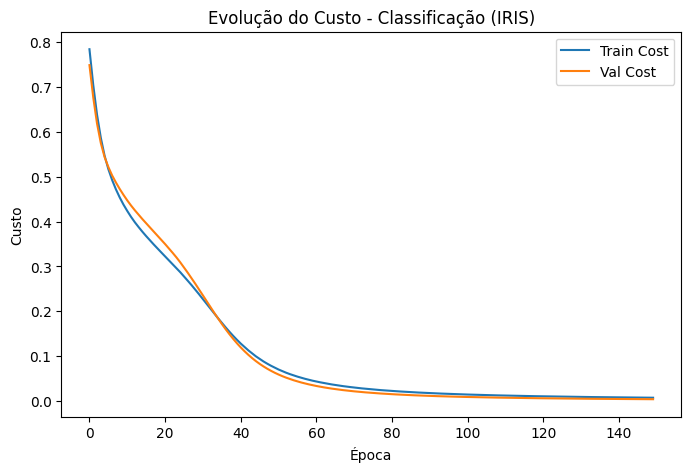

Modelo exportado para modelo_iris.json


In [46]:
# -------------------------
# Execução Principal
# -------------------------
if __name__ == "__main__":
    print("Selecione o exemplo a ser executado:")
    print("1 - Classificação (IRIS)")
    print("2 - Regressão (California Housing)")
    escolha = input("Digite 1 ou 2: ")
    if escolha == "1":
        run_classification_example()
    elif escolha == "2":
        run_regression_example()
    else:
        print("Opção inválida.")
